<h1> Sampling, running and generating data from Brock and Hommes </h1>
<p> This notebook highlights how we suggest you generate your synthetic data from the brock and hommes model.</p>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import random
sys.path.append('./')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm



from abm_cali.samplers.centered_lhs import LhsCenter
from abm_cali.models.brock_and_hommes import brock_and_hommes

<h2>Generating a parameter sample</h2>
<p>To help you quickly generate data to calibrate your models against we have provided three samplers. 
    A random sampler, a Latin Hyper Cuber sample and a Sobol sampler. If you feel your calibration efforts
    would be helped by implementing a different sampler please feel free.</p>

In [2]:
# All the samplers take a dictionary of parameter names and bounds to sample between.
calibration_params = {'names': ['beta',  'R', 'b1', 'b2', 'g1 ', 'g2', 'C', 'eta',
                               'n1', 'alpha', 'sigma', 'epsilon_sigma', 'epsilon_mu'],
                     'bounds': [[0.0, 10.0],
                                [1.01, 1.1],
                                [-2.0, 2.0],
                                [-2.0, 2.0],
                                [-2.0, 2.0],
                                [-2.0, 2.0],
                                [0.0, 5.0],
                                [0.0, 1.0],
                                [0.0, 1.0],
                                [0.0001, 2.0],
                                [0.0001, 100.0],
                                [0.0001, 100.0],
                                [-1.0, 1.0]]}

In [3]:
# Simply pass this dictionary when construting your sampler.
sampler = LhsCenter(parameters=calibration_params)
# Specify how many samples you wish to generate.
samples = sampler.sample(int(1E+5))

<h2>Running the model</h2>
<p>The brock and hommes model provided has a run method. This takes the number of steps you want to run your model for, 
an initial series of market returns and the parameters for the given run. It returns a time series of return data and if the run finished. If the time series starts to diverge rapidly the simulation will be stopped.</p>

In [4]:
def runner(parameter_vector, steps=10000, model = brock_and_hommes.ABM(100)):
    data, finished = model.run(steps, [260, 261.56], parameter_vector)
    flat_data = np.ndarray.flatten(data)
    df_data = pd.DataFrame(flat_data)
    percentage_change = pd.DataFrame.pct_change(df_data)
    return {'has_finished': finished, 'params': parameter_vector,'time_series': data[:,0], 'percentage_change': np.ndarray.flatten(percentage_change.to_numpy())}

In [5]:
# lets run this for all the samples we produced.
run_data = Parallel(n_jobs=-1)(delayed(runner)(param_vec) for param_vec in tqdm(samples))

<h2>Inspecting the data</h2>
<p>From looking at the data we see, a) lots of runs have not finished, b) lots of the results quickly diverge</p>

In [6]:
df = pd.DataFrame(run_data)
df.head()

,has_finished,params,percentage_change,time_series
0,False,"[8.253350000000001, 1.03982015, 0.078460000000...","[nan, 0.641367741126373, -0.5776514937395976, ...","[261.56, 429.3161463690141, 181.32103313242538..."
1,False,"[7.94745, 1.03947455, -0.7635000000000001, -0....","[nan, 0.4906181740900639, -0.26074966600607785...","[261.56, 389.8860896149971, 288.22342196747087..."
2,True,"[5.66535, 1.09511975, -1.6013, 0.8727800000000...","[nan, -0.0710886079631281, 0.00303842720523772...","[423.63337788195423, 393.51787076160826, 394.7..."
3,False,"[2.1622500000000002, 1.03760795, -0.1442599999...","[nan, 0.6478997307812902, -0.09778750005255343...","[261.56, 431.02465358315425, 388.8758302482397..."
4,False,"[5.655650000000001, 1.05484565, -0.91469999999...","[nan, 0.48843267367317544, 0.6225345680164582,...","[261.56, 389.3144501259558, 631.6761531576826,..."


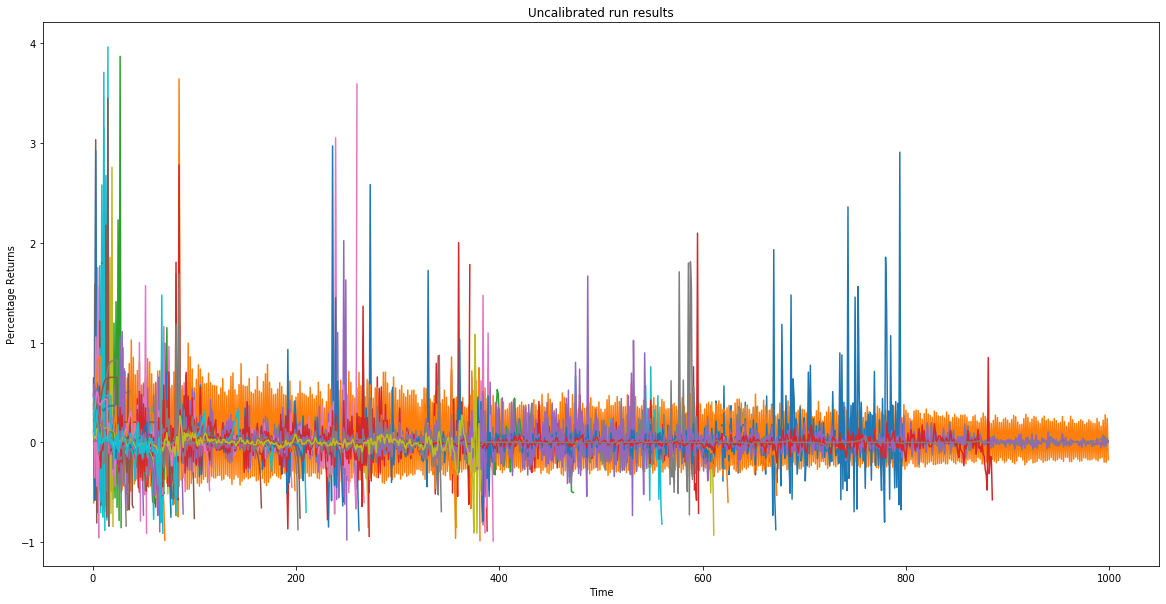

In [7]:
for time_series in df['percentage_change'][:100]:
    plt.rc('figure', figsize=[20, 10])
    plt.plot(time_series[:1000])
    plt.ylabel('Percentage Returns')
    plt.xlabel('Time')
    plt.title('Uncalibrated run results')

<h2>I guess we should calibrate...</h2> 
<p>Lets dump the data to parquet so we have something to calibrate against</p>

In [10]:
df.to_parquet('ten_thosand_runs_ten_thosand_ticks')